# Nepali Sign Language Recognition - Transfer Learning

# 1. Import required libraries

In [1]:
# Ignore warnings
import logging, os, warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import save_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import numpy as np
import random

In [3]:
# Add path for helper_functions
import sys
sys.path.append("/home/aashish/Downloads/Nepali-Sign-Language-Recognition")
from helper_functions import show_images, plot_curves, compare_historys

In [17]:
# Set Devanagari font
plt.rcParams['font.family'] = 'Noto Sans Devanagari'

## 2. Data exploration

In [5]:
data_dir = pathlib.Path("/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['क' 'क्ष' 'ख' 'ग' 'घ' 'ङ' 'च' 'छ' 'ज' 'ज्ञ' 'झ' 'ञ' 'ट' 'ठ' 'ड' 'ढ' 'ण'
 'त' 'त्र' 'थ' 'द' 'ध' 'न' 'प' 'फ' 'ब' 'भ' 'म' 'य' 'र' 'ल' 'व' 'श' 'ष' 'स'
 'ह' '०' '१' '२' '३' '४' '५' '६' '७' '८' '९']


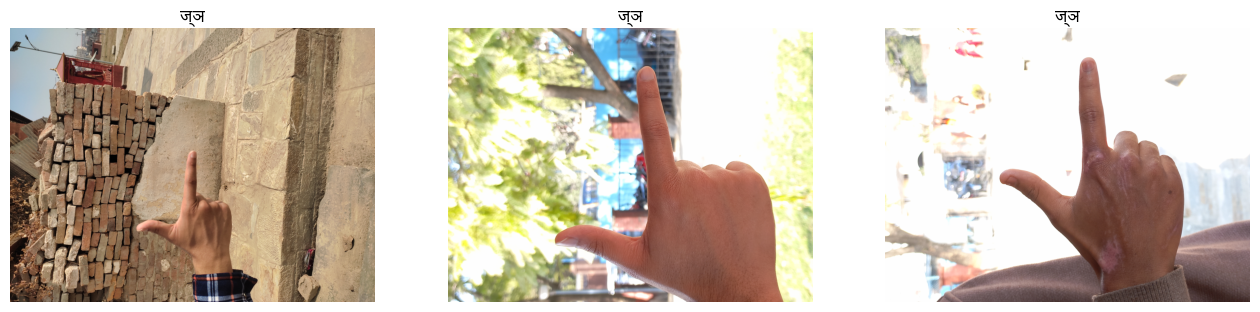

In [6]:
target_directory = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train/"
class_name = "ज्ञ"
show_images(target_directory, class_name)

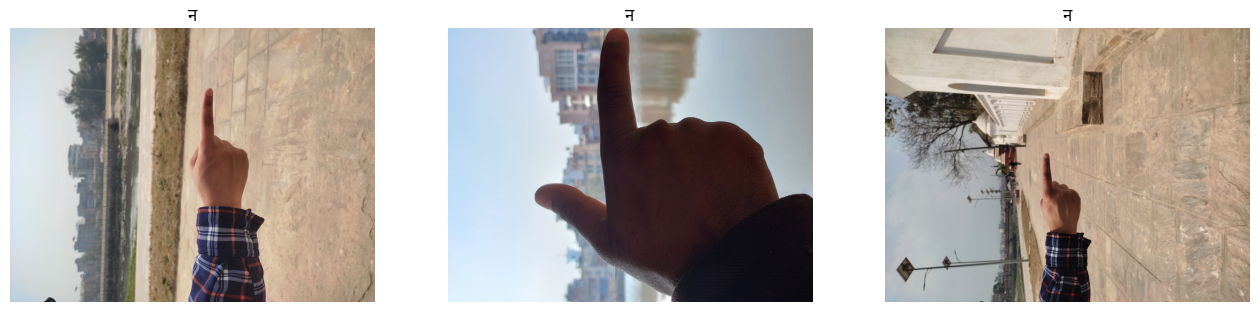

In [7]:
target_directory = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train/"
class_name = "न"
show_images(target_directory, class_name)

## 3. Data Preprocessing

In [5]:
# Define path to train, test and validation set
train_dir = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train/"
val_dir = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/validation/"
test_dir = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/test/"

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical", 
                                                                 image_size=IMG_SIZE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir, 
                                                                label_mode="categorical", 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=False)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode="categorical", 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=False)

Found 1664 files belonging to 46 classes.
Found 357 files belonging to 46 classes.
Found 384 files belonging to 46 classes.


## 4. Model building (feature extraction) 

In [7]:
# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation_layer")

In [8]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name ="input_layer")
x = data_augmentation(inputs) # augment images
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
eff_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="eff_transfer_learning_model")

In [9]:
# Check the layers in base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [10]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
eff_model.summary()

Model: "eff_transfer_learning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 46)             │        58,926 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,108,497 (15.67 MB)

 Trainable params: 58,926 (230.18 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

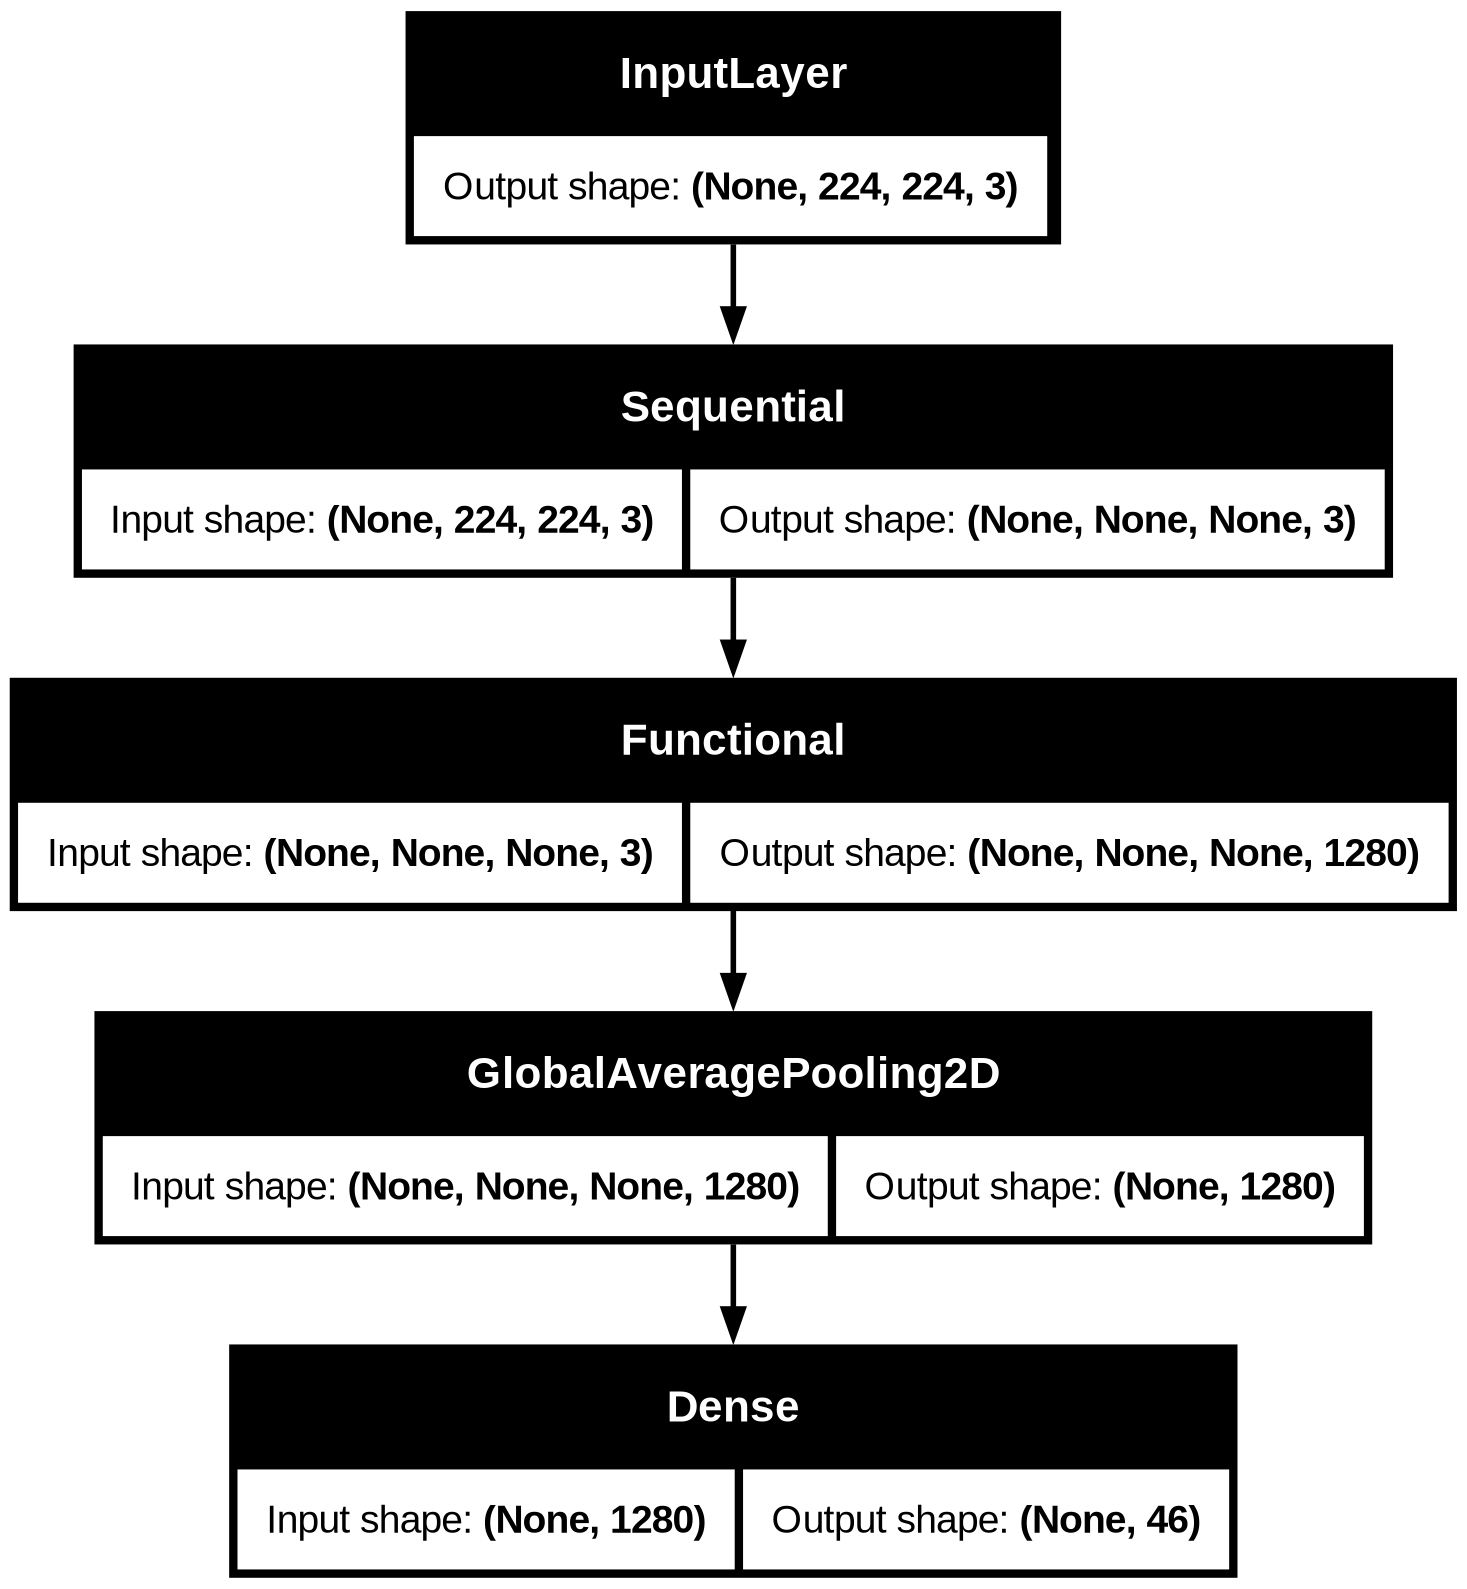

In [12]:
tf.keras.utils.plot_model(eff_model, "eff_transfer_learning_model.png", show_shapes=True)

In [13]:
# Compile the model
eff_model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(), 
              metrics=["accuracy"])

# Fit the model
eff_model_history_2 = eff_model.fit(train_data, 
                              epochs=25, 
                              validation_data=val_data
                             )

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.0506 - loss: 3.8120 - val_accuracy: 0.1429 - val_loss: 3.2695
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.2317 - loss: 3.0855 - val_accuracy: 0.2577 - val_loss: 2.8534
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.3395 - loss: 2.7050 - val_accuracy: 0.2941 - val_loss: 2.6312
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.4433 - loss: 2.3727 - val_accuracy: 0.3417 - val_loss: 2.4360
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.4940 - loss: 2.1663 - val_accuracy: 0.3501 - val_loss: 2.3020
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.5682 - loss: 2.0252 - val_accuracy: 0.3697 - val_loss: 2.1773
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.5979 - loss: 1.8194 - val_accuracy: 0.4174 - val_loss: 2.0713
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.6376 - loss: 1.6805 - val_accuracy: 0

In [14]:
# Evaluate the model
eff_model_eval = eff_model.evaluate(test_data)
print(eff_model_eval)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.5400 - loss: 1.5193
[1.3651524782180786, 0.5963541865348816]


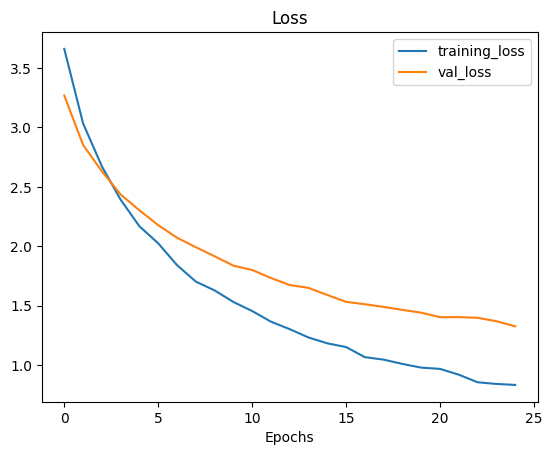

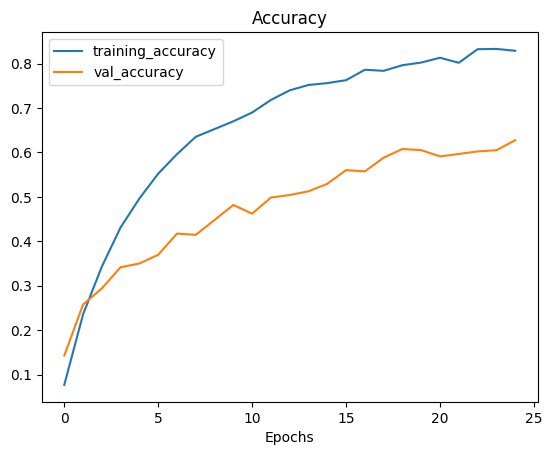

In [15]:
# Restore the default rc settings
plt.rcdefaults()

# Plot loss curves
plot_curves(eff_model_history_2)

## 5. Saving the `eff_model`

In [16]:
eff_model.save("eff_transfer_learning_model.keras")

## 6. Feature Extraction using MobilenetV3 

In [7]:
# Setup data augmentation
data_augmentation_1 = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomContrast(0.2),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation_layer")

In [8]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.MobileNetV3Large(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name ="input_layer")
x = data_augmentation_1(inputs) # augment images
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
mobv3_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mobv3_transfer_learning_model")

In [9]:
# Check the layers in base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer
1 rescaling
2 conv
3 conv_bn
4 activation
5 expanded_conv_depthwise
6 expanded_conv_depthwise_bn
7 re_lu
8 expanded_conv_project
9 expanded_conv_project_bn
10 expanded_conv_add
11 expanded_conv_1_expand
12 expanded_conv_1_expand_bn
13 re_lu_1
14 expanded_conv_1_depthwise_pad
15 expanded_conv_1_depthwise
16 expanded_conv_1_depthwise_bn
17 re_lu_2
18 expanded_conv_1_project
19 expanded_conv_1_project_bn
20 expanded_conv_2_expand
21 expanded_conv_2_expand_bn
22 re_lu_3
23 expanded_conv_2_depthwise
24 expanded_conv_2_depthwise_bn
25 re_lu_4
26 expanded_conv_2_project
27 expanded_conv_2_project_bn
28 expanded_conv_2_add
29 expanded_conv_3_expand
30 expanded_conv_3_expand_bn
31 re_lu_5
32 expanded_conv_3_depthwise_pad
33 expanded_conv_3_depthwise
34 expanded_conv_3_depthwise_bn
35 re_lu_6
36 expanded_conv_3_squeeze_excite_avg_pool
37 expanded_conv_3_squeeze_excite_conv
38 expanded_conv_3_squeeze_excite_relu
39 expanded_conv_3_squeeze_excite_conv_1
40 re_lu_7
41 expanded_conv_3_

In [10]:
base_model.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, None,      │        432 │ rescaling[0][0]   │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, None,      │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ conv_bn[0][0]     │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, None,      │          0 │ expanded_conv_de… │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, None,      │          0 │ activation[0][0], │
│ (Add)               │ None, 16)         │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, None,      │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, None,      │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, None,      │          0 │ expanded_conv_1_… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

In [11]:
mobv3_model.summary()

Model: "mobv3_transfer_learning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, None, None,     │     2,996,352 │
│                                 │ 960)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 46)             │        44,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,040,558 (11.60 MB)

 Trainable params: 44,206 (172.68 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

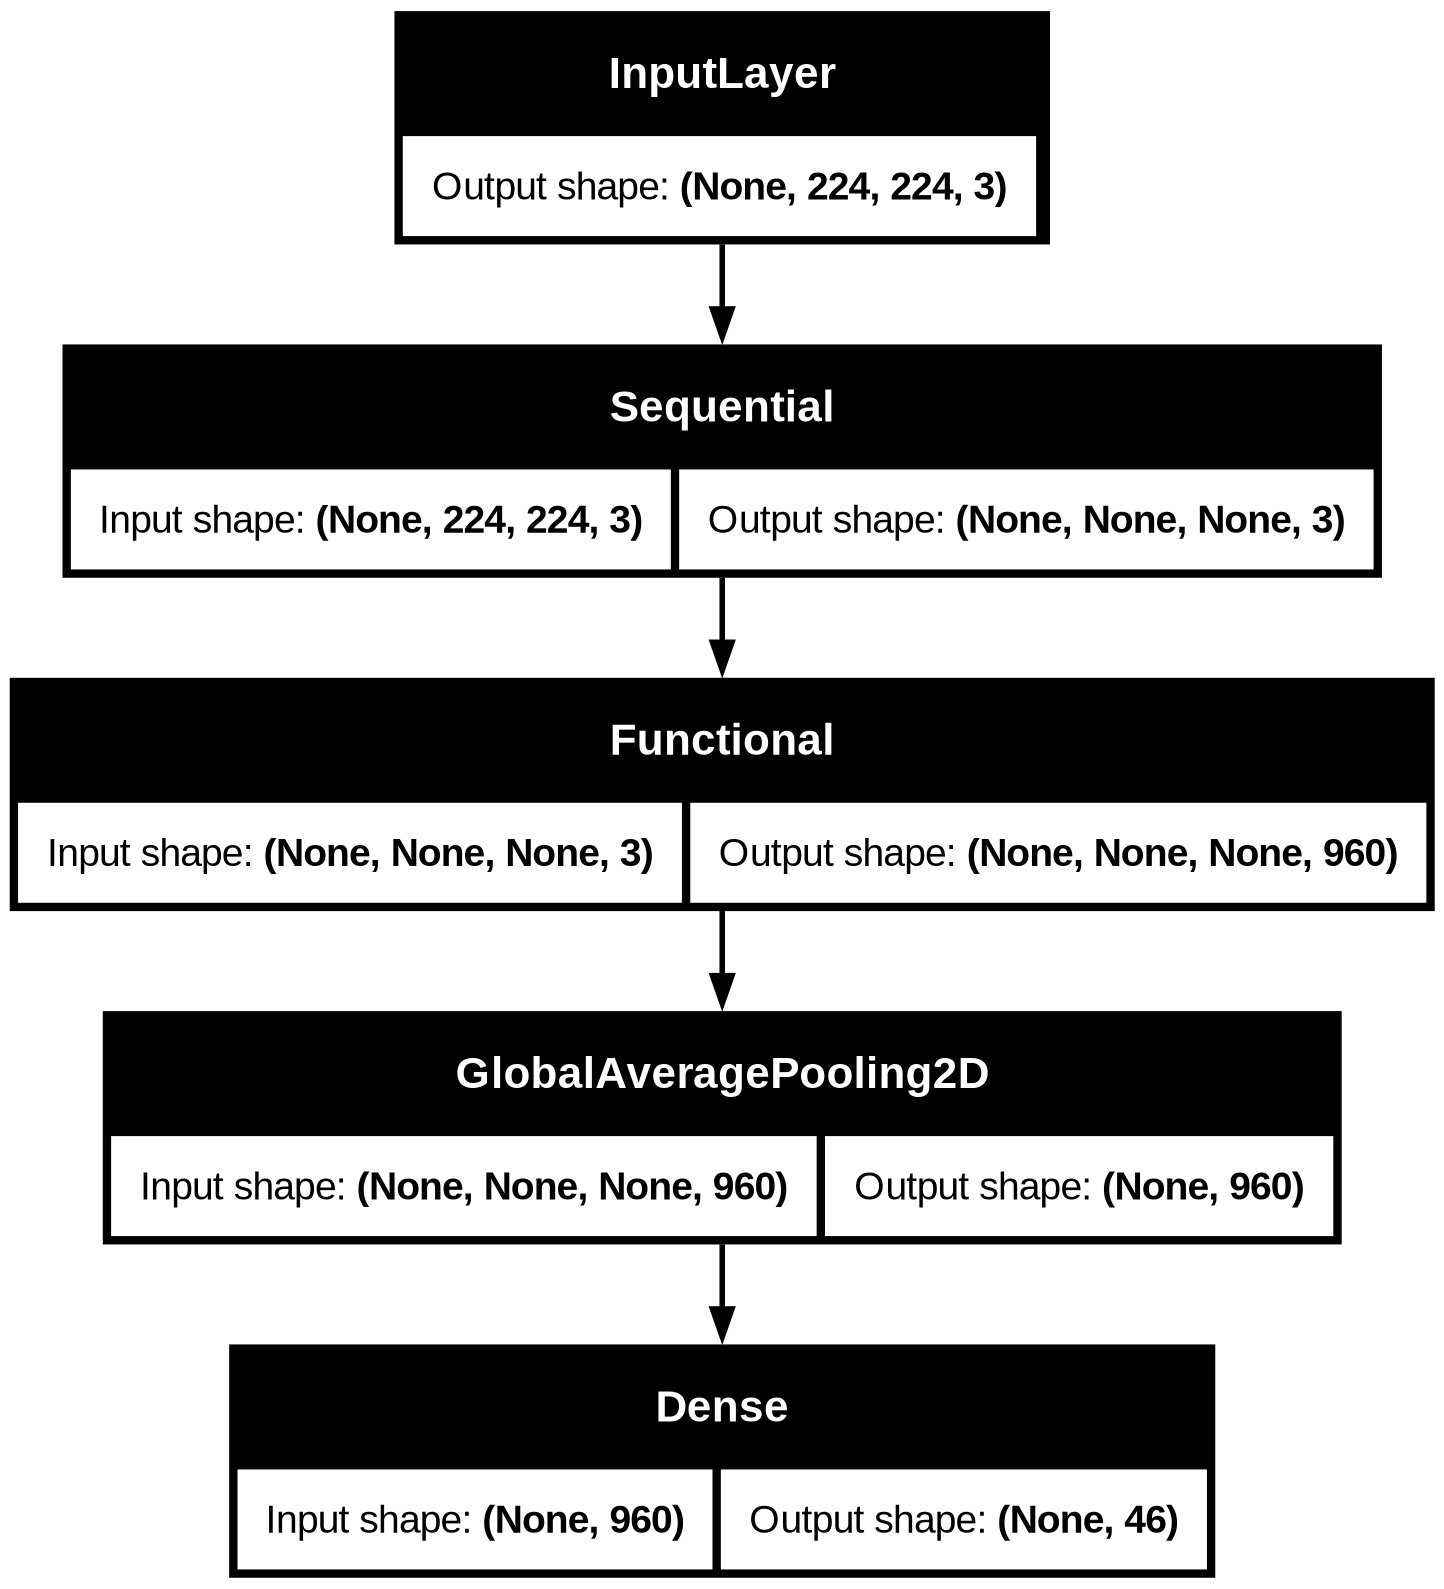

In [12]:
tf.keras.utils.plot_model(mobv3_model, "mobv3_transfer_learning_model.png", show_shapes=True)

In [13]:
# Compile the model
mobv3_model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(), 
              metrics=["accuracy"])

# Fit the model
mobv3_model_history = mobv3_model.fit(train_data, 
                              epochs=25,
                              validation_data=val_data
                             )

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - accuracy: 0.0430 - loss: 4.1482 - val_accuracy: 0.1204 - val_loss: 3.3579
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.2067 - loss: 3.0753 - val_accuracy: 0.2185 - val_loss: 2.8674
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.3242 - loss: 2.5596 - val_accuracy: 0.2941 - val_loss: 2.5216
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.4161 - loss: 2.2545 - val_accuracy: 0.3165 - val_loss: 2.3584
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.4792 - loss: 1.9807 - val_accuracy: 0.4062 - val_loss: 2.0927
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.5501 - loss: 1.7725 - val_accuracy: 0.4370 - val_loss: 1.9753
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.5956 - loss: 1.6101 - val_accuracy: 0.4314 - val_loss: 1.8853
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.6393 - loss: 1.4481 - val_accuracy: 0

In [14]:
# Evaluate the model
mobv3_model_eval = mobv3_model.evaluate(test_data)
print(mobv3_model_eval)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.5909 - loss: 1.5097
[1.3131831884384155, 0.6484375]


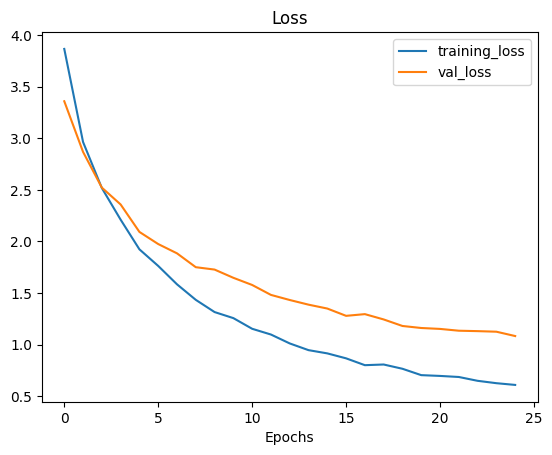

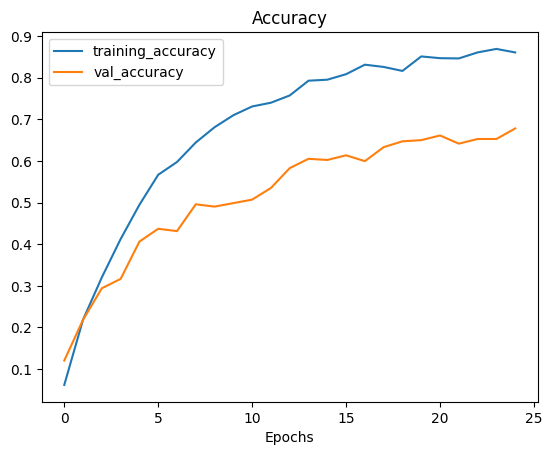

In [15]:
# Restore the default rc settings
plt.rcdefaults()

# Plot loss curves
plot_curves(mobv3_model_history)

## 7. Saving the `mobv3_model`

In [16]:
mobv3_model.save("mobv3_transfer_learning_model.keras")

## 8. Finetuning the `eff_model` 

In [18]:
eff_model.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation_layer, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <GlobalAveragePooling2D name=global_avg_pool, built=True>,
 <Dense name=output_layer, built=True>]

In [19]:
# Check trainable layers
for layer in eff_model.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=data_augmentation_layer, built=True> True
<Functional name=efficientnetb0, built=True> False
<GlobalAveragePooling2D name=global_avg_pool, built=True> True
<Dense name=output_layer, built=True> True


In [20]:
# check trainable layers in base_model .i.e. EfficientNetB0
for i, layer in enumerate(eff_model.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [21]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [22]:
# Recompile model with lower learning rate
eff_model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [23]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(eff_model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [24]:
eff_model.summary(show_trainable=True)

Model: "eff_transfer_learning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ data_augmentation_layer     │ (None, None, None, 3) │          0 │   -   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetb0 (Functional) │ (None, None, None,    │  4,049,571 │   Y   │
│                             │ 1280)                 │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_avg_pool             │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 46)            │     58,926 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 4,108,497 (15.67 MB)

 Trainable params: 952,158 (3.63 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [25]:
# Fine-tune the model for 10 epochs
eff_model_finetune_history = eff_model.fit(train_data, 
                    epochs=10, 
                    validation_data=val_data)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.8133 - loss: 0.9062 - val_accuracy: 0.6723 - val_loss: 1.2086
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.8626 - loss: 0.7131 - val_accuracy: 0.6639 - val_loss: 1.1469
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.8826 - loss: 0.6452 - val_accuracy: 0.6807 - val_loss: 1.1068
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.8756 - loss: 0.6285 - val_accuracy: 0.6919 - val_loss: 1.0628
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.8835 - loss: 0.6173 - val_accuracy: 0.7031 - val_loss: 1.0184
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.9015 - loss: 0.5283 - val_accuracy: 0.7087 - val_loss: 0.9904
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.9129 - loss: 0.5168 - val_accuracy: 0.7255 - val_loss: 0.9393
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.9173 - loss: 0.4721 - val_accuracy: 0

In [26]:
# Evaluate the fine tuned model
eff_model_finetuned_eval = eff_model.evaluate(test_data)
print(eff_model_eval)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.6911 - loss: 1.0130
[1.3651524782180786, 0.5963541865348816]


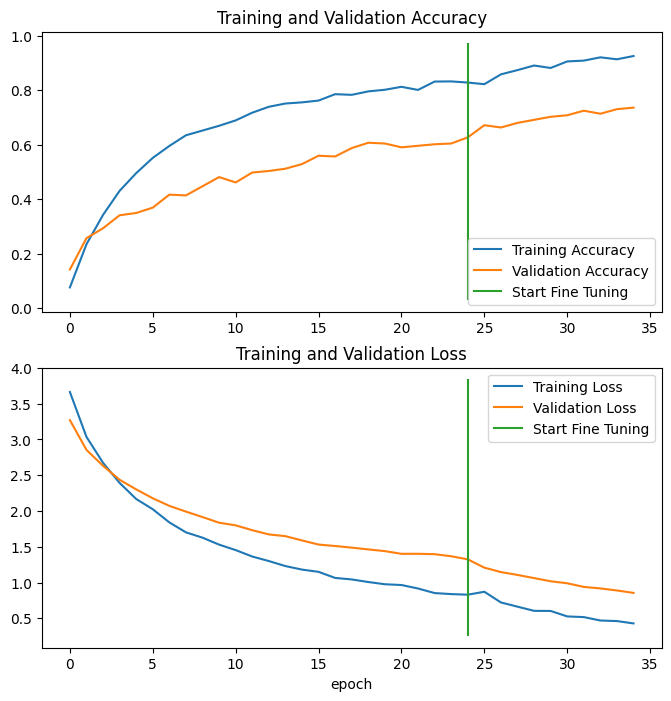

In [27]:
# Restore the default rc settings
plt.rcdefaults()

# Compare the historys of feature extraction model with fine-tuning model
compare_historys(original_history=eff_model_history_2, 
                 new_history=eff_model_finetune_history, 
                 initial_epochs=25)

## 9. Save finetuned `eff_model` 

In [31]:
eff_model.save("eff_transfer_learning/eff_model_finetuned.keras")
eff_model.save("eff_transfer_learning/eff_model_finetuned.h5")

## 10. Finetuning the `mobv3_model`  

In [18]:
mobv3_model.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation_layer, built=True>,
 <Functional name=MobileNetV3Large, built=True>,
 <GlobalAveragePooling2D name=global_avg_pool, built=True>,
 <Dense name=output_layer, built=True>]

In [20]:
# Check trainable layers
for layer in mobv3_model.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=data_augmentation_layer, built=True> True
<Functional name=MobileNetV3Large, built=True> False
<GlobalAveragePooling2D name=global_avg_pool, built=True> True
<Dense name=output_layer, built=True> True


In [21]:
# check trainable layers in base_model .i.e. MobilenetV3Large
for i, layer in enumerate(mobv3_model.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 conv False
3 conv_bn False
4 activation False
5 expanded_conv_depthwise False
6 expanded_conv_depthwise_bn False
7 re_lu False
8 expanded_conv_project False
9 expanded_conv_project_bn False
10 expanded_conv_add False
11 expanded_conv_1_expand False
12 expanded_conv_1_expand_bn False
13 re_lu_1 False
14 expanded_conv_1_depthwise_pad False
15 expanded_conv_1_depthwise False
16 expanded_conv_1_depthwise_bn False
17 re_lu_2 False
18 expanded_conv_1_project False
19 expanded_conv_1_project_bn False
20 expanded_conv_2_expand False
21 expanded_conv_2_expand_bn False
22 re_lu_3 False
23 expanded_conv_2_depthwise False
24 expanded_conv_2_depthwise_bn False
25 re_lu_4 False
26 expanded_conv_2_project False
27 expanded_conv_2_project_bn False
28 expanded_conv_2_add False
29 expanded_conv_3_expand False
30 expanded_conv_3_expand_bn False
31 re_lu_5 False
32 expanded_conv_3_depthwise_pad False
33 expanded_conv_3_depthwise False
34 expanded_conv_3_depthwise_bn

In [22]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [23]:
# Recompile model with lower learning rate
mobv3_model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [24]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(mobv3_model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 conv False
3 conv_bn False
4 activation False
5 expanded_conv_depthwise False
6 expanded_conv_depthwise_bn False
7 re_lu False
8 expanded_conv_project False
9 expanded_conv_project_bn False
10 expanded_conv_add False
11 expanded_conv_1_expand False
12 expanded_conv_1_expand_bn False
13 re_lu_1 False
14 expanded_conv_1_depthwise_pad False
15 expanded_conv_1_depthwise False
16 expanded_conv_1_depthwise_bn False
17 re_lu_2 False
18 expanded_conv_1_project False
19 expanded_conv_1_project_bn False
20 expanded_conv_2_expand False
21 expanded_conv_2_expand_bn False
22 re_lu_3 False
23 expanded_conv_2_depthwise False
24 expanded_conv_2_depthwise_bn False
25 re_lu_4 False
26 expanded_conv_2_project False
27 expanded_conv_2_project_bn False
28 expanded_conv_2_add False
29 expanded_conv_3_expand False
30 expanded_conv_3_expand_bn False
31 re_lu_5 False
32 expanded_conv_3_depthwise_pad False
33 expanded_conv_3_depthwise False
34 expanded_conv_3_depthwise_bn

In [25]:
mobv3_model.summary(show_trainable=True)

Model: "mobv3_transfer_learning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ data_augmentation_layer     │ (None, None, None, 3) │          0 │   -   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ MobileNetV3Large            │ (None, None, None,    │  2,996,352 │   Y   │
│ (Functional)                │ 960)                  │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_avg_pool             │ (None, 960)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 46)            │     44,206 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 3,040,558 (11.60 MB)

 Trainable params: 585,006 (2.23 MB)

 Non-trainable params: 2,455,552 (9.37 MB)

In [26]:
# Fine-tune the model for 10 epochs
mobv3_model_finetune_history = mobv3_model.fit(train_data, 
                    epochs=10, 
                    validation_data=val_data)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 722ms/step - accuracy: 0.7837 - loss: 0.8757 - val_accuracy: 0.6639 - val_loss: 1.0321
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 507ms/step - accuracy: 0.8912 - loss: 0.5888 - val_accuracy: 0.6667 - val_loss: 1.0523
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - accuracy: 0.9006 - loss: 0.5102 - val_accuracy: 0.6891 - val_loss: 1.0070
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 384ms/step - accuracy: 0.9187 - loss: 0.4299 - val_accuracy: 0.6807 - val_loss: 1.0451
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 345ms/step - accuracy: 0.9143 - loss: 0.4085 - val_accuracy: 0.7087 - val_loss: 0.9853
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - accuracy: 0.9240 - loss: 0.4016 - val_accuracy: 0.7059 - val_loss: 0.9475
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 335ms/step - accuracy: 0.9436 - loss: 0.3498 - val_accuracy: 0.7311 - val_loss: 0.8782
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 310ms/step - accuracy: 0.9184 - loss: 0.3676 - val_accu

In [27]:
# Evaluate the fine tuned model
mobv3_model_finetuned_eval = mobv3_model.evaluate(test_data)
print(mobv3_model_finetuned_eval)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.7314 - loss: 1.0614
[0.9402299523353577, 0.7395833134651184]


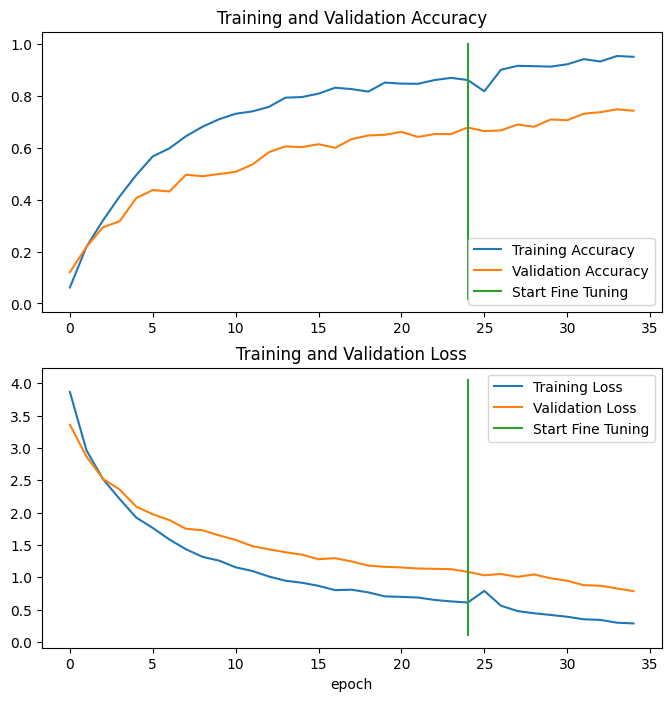

In [28]:
# Restore the default rc settings
plt.rcdefaults()

# Compare the historys of feature extraction model with fine-tuning model
compare_historys(original_history=mobv3_model_history, 
                 new_history=mobv3_model_finetune_history, 
                 initial_epochs=25)

## 11. Save finetuned `mobv3_model` 

In [30]:
mobv3_model.save("mobv3_model_finetuned/mobv3_model_finetuned.keras")
mobv3_model.save("mobv3_model_finetuned/mobv3_model_finetuned.keras")